# ML Classifier Copies - Wine Model Example

An example where we take an existing "black box" classifier model of the publicly available [Wine Quality dataset](https://archive-beta.ics.uci.edu/ml/datasets/wine+quality), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.evaluations import multivariable_density_comparison
from presc.copies.sampling import reduce_feature_space, uniform_sampling, normal_sampling, labeling

from ML_copies_original_models import WinesModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

In [4]:
wine_model = WinesModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [5]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression())])
tree_normal_classifier = DecisionTreeClassifier()
svm_normal_classifier = Pipeline([('scaler', StandardScaler()), 
                                  ('SVC_classifier', SVC(kernel="linear"))])

In [6]:
feature_description = wine_model.feature_description

In [7]:
balance_parameters={"max_iter": 50, "nbatch": 1500, "verbose": False}
log_normal_copy = ClassifierCopy(wine_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="recommend",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

tree_normal_copy = ClassifierCopy(wine_model.model, tree_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=2000, random_state=42,
                                  feature_parameters=feature_description, label_col="recommend",
                                  **balance_parameters) 
tree_normal_copy_training_data = tree_normal_copy.copy_classifier(get_training_data=True)

svm_normal_copy = ClassifierCopy(wine_model.model, svm_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="recommend",
                                 **balance_parameters) 
svm_normal_copy_training_data = svm_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [8]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                wine_model.X_test.join(wine_model.y_test), label_col="recommend"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * Decision tree copy:")
synthetic_tree_normal_test_data = tree_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_tree_normal_copy = tree_normal_copy.evaluation_summary(test_data=Dataset(
                                                wine_model.X_test.join(wine_model.y_test), label_col="recommend"), 
                                                                  synthetic_data=synthetic_tree_normal_test_data)

print("\n * Linear SVM copy:")
synthetic_svm_normal_test_data = svm_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_svm_normal_copy = svm_normal_copy.evaluation_summary(test_data=Dataset(
                                                wine_model.X_test.join(wine_model.y_test), label_col="recommend"), 
                                                                  synthetic_data=synthetic_svm_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.8523
Copy Model Accuracy (test)              0.8040
Empirical Fidelity Error (synthetic)    0.0400
Empirical Fidelity Error (test)         0.1034
Replacement Capability (synthetic)      0.9600
Replacement Capability (test)           0.9433

 * Decision tree copy:
Original Model Accuracy (test)          0.8523
Copy Model Accuracy (test)              0.7894
Empirical Fidelity Error (synthetic)    0.0650
Empirical Fidelity Error (test)         0.1426
Replacement Capability (synthetic)      0.9350
Replacement Capability (test)           0.9261

 * Linear SVM copy:
Original Model Accuracy (test)          0.8523
Copy Model Accuracy (test)              0.7836
Empirical Fidelity Error (synthetic)    0.0445
Empirical Fidelity Error (test)         0.1313
Replacement Capability (synthetic)      0.9555
Replacement Capability (test)           0.9194


[Index](#Index)  
  
  


<a name="Densities">  


### Summary of class density projections for each classifier

The data points for the visualization of the original classifier and copies topologies must be sampled homogeneously throughout the feature space to avoid introducing spurious shapes in the projected density distributions. **uniform_sampling** is a good option for that. 

**grid_sampling** is not recommended because it samples the specific interval points and displays density peaks.

In [9]:
# Recommended class colors
colors = {0:"red", 1:"royalblue"}

In [10]:
# Reduce feature space to increase sampling efficiency with the uniform_sampling
reduced_feature_space = reduce_feature_space(feature_description, sigmas=2)

In [11]:
visualization_data = uniform_sampling(nsamples=5000, feature_parameters=reduced_feature_space)

visualization_original = labeling(visualization_data, wine_model.model, label_col="recommend")
visualization_log = labeling(visualization_data, log_normal_copy.copy, label_col="recommend")
visualization_tree = labeling(visualization_data, tree_normal_copy.copy, label_col="recommend")
visualization_svm = labeling(visualization_data, svm_normal_copy.copy, label_col="recommend")

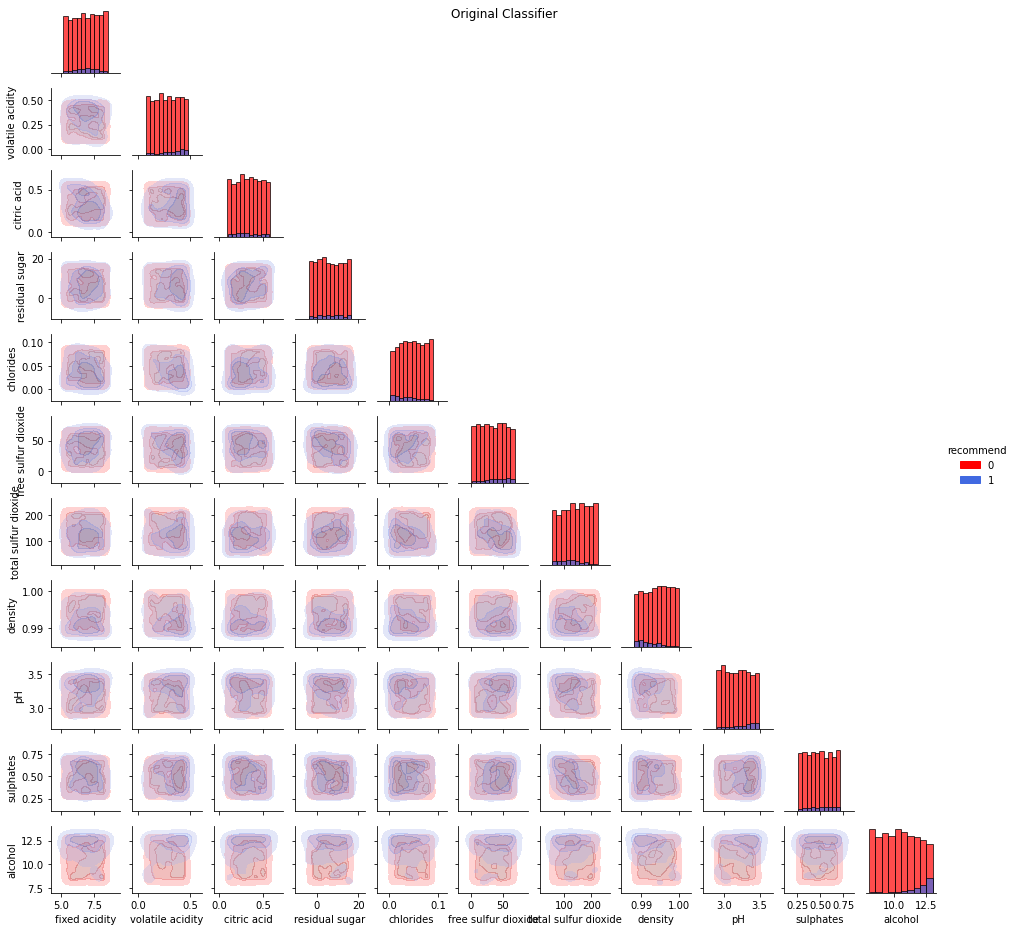

In [12]:
g = sns.PairGrid(visualization_original.df, hue="recommend", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_original.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4, common_norm=False)
g = g.add_legend()
g = g.fig.suptitle('Original Classifier')
plt.show()

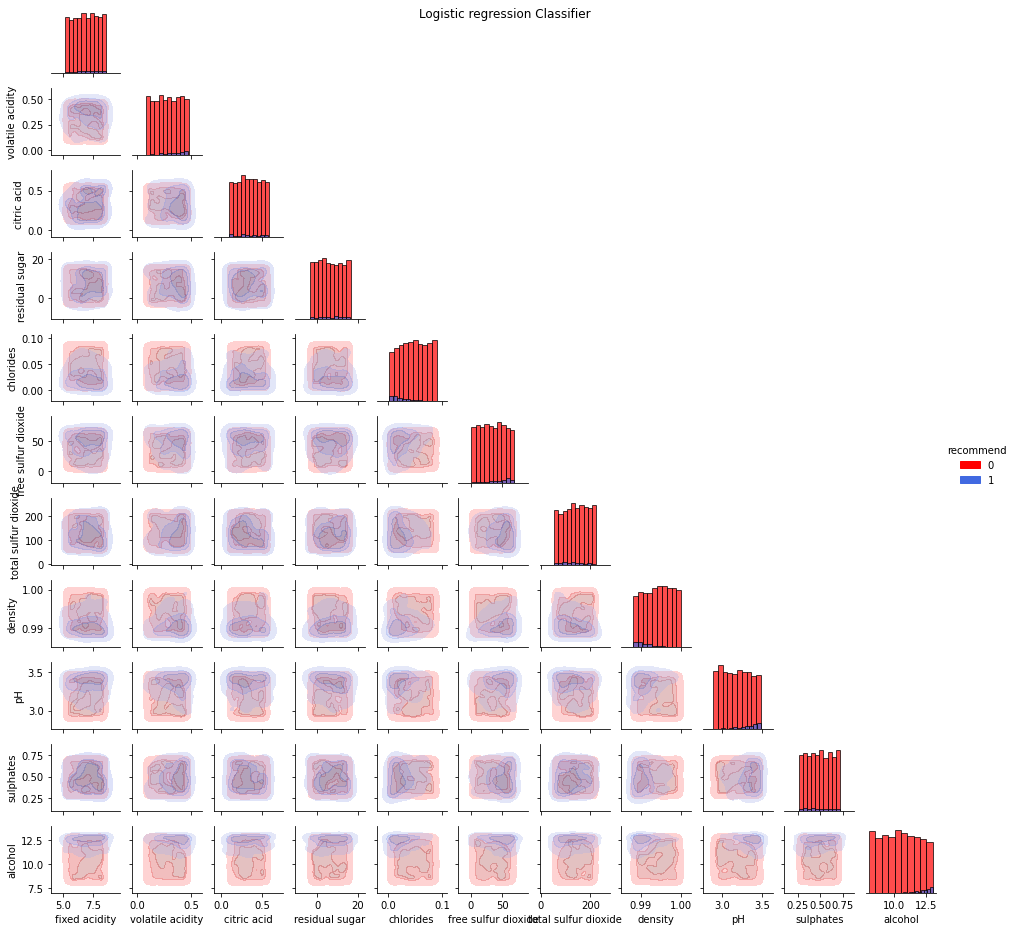

In [13]:
g = sns.PairGrid(visualization_log.df, hue="recommend", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_log.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4, common_norm=False)
g = g.add_legend()
g = g.fig.suptitle('Logistic regression Classifier')
plt.show()

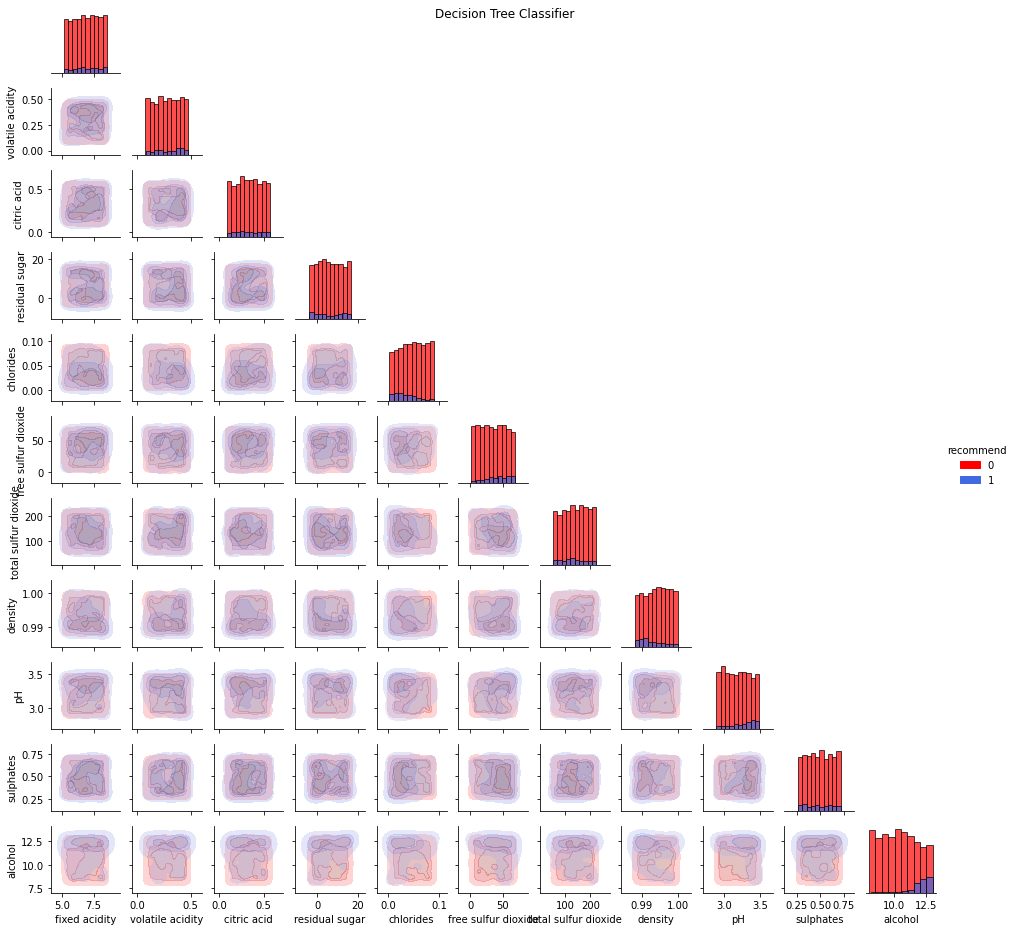

In [14]:
g = sns.PairGrid(visualization_tree.df, hue="recommend", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_tree.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4, common_norm=False)
g = g.add_legend()
g = g.fig.suptitle('Decision Tree Classifier')
plt.show()

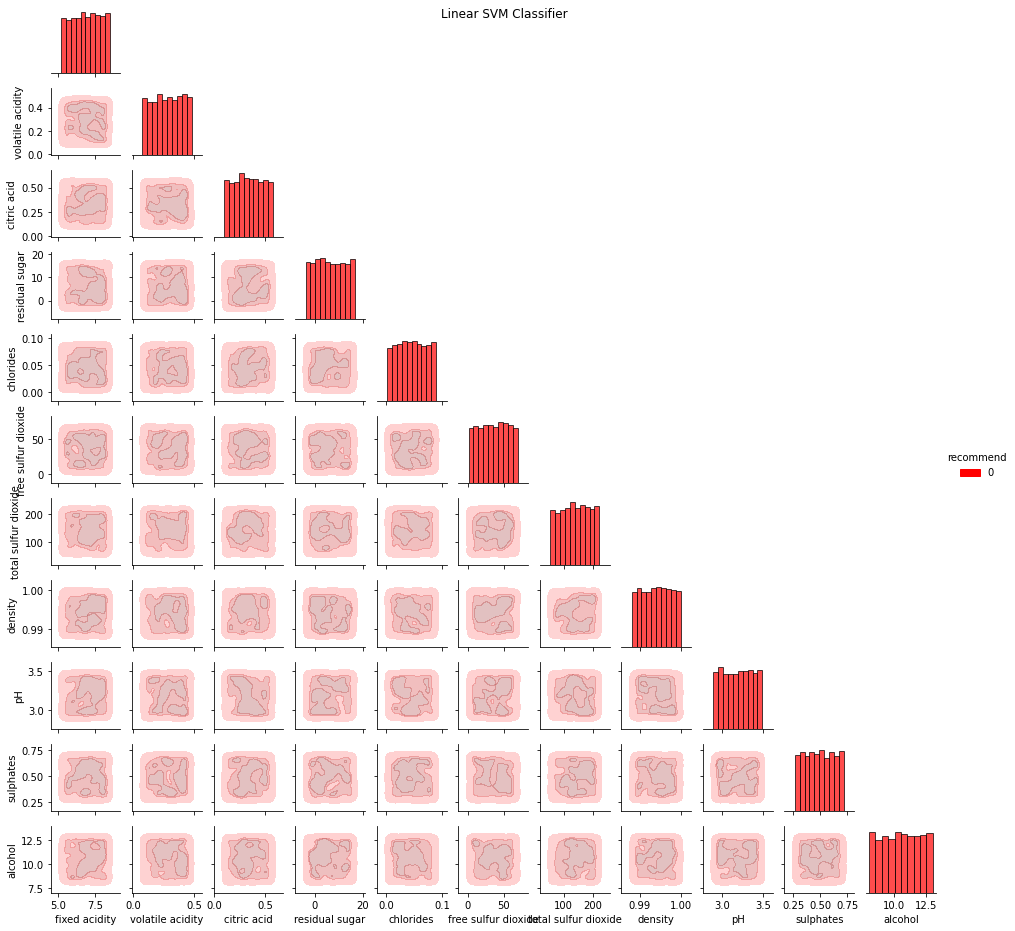

In [15]:
g = sns.PairGrid(visualization_svm.df, hue="recommend", palette=colors, corner=True, height=1.2,
                 vars=[var_name for var_name in visualization_svm.feature_names[:]])
g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
g = g.map_lower(sns.kdeplot, alpha=0.3, shade=True, n_levels=4, common_norm=False)
g = g.add_legend()
g = g.fig.suptitle('Linear SVM Classifier')
plt.show()

[Index](#Index)  

<a name="Densities">  


### Examples of detailed class density projections for each classifier

In [16]:
# Common parameters
titles = ["Original Classifier", "Logistic Regression Classifier Copy", 
          "Decision Tree Classifier Copy", "Linear SVM Classifier Copy"]
datasets = [visualization_original.df, visualization_log.df, 
            visualization_tree.df, visualization_svm.df]
other_kwargs = {"alpha":0.3, "common_norm":False, "palette": colors, "shade": True, "n_levels": 4,
                "legend": False}

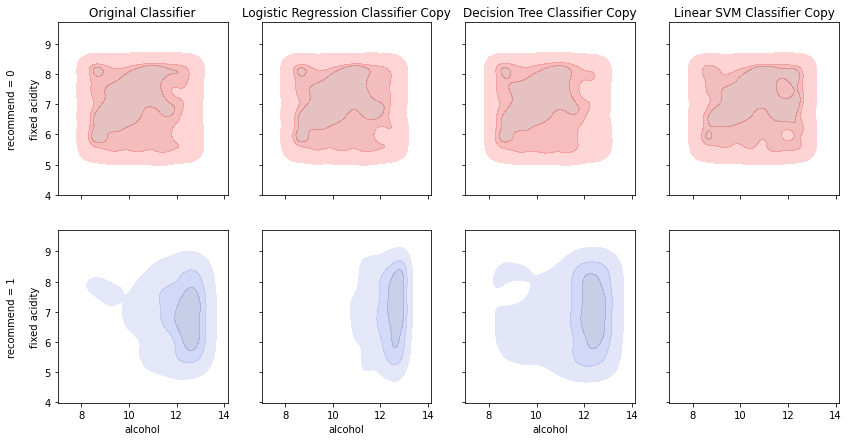

In [17]:
%%capture --no-display
feature1 = "alcohol"
feature2 = "fixed acidity"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, 
                                     label_col="recommend", titles=titles, other_kwargs=other_kwargs)

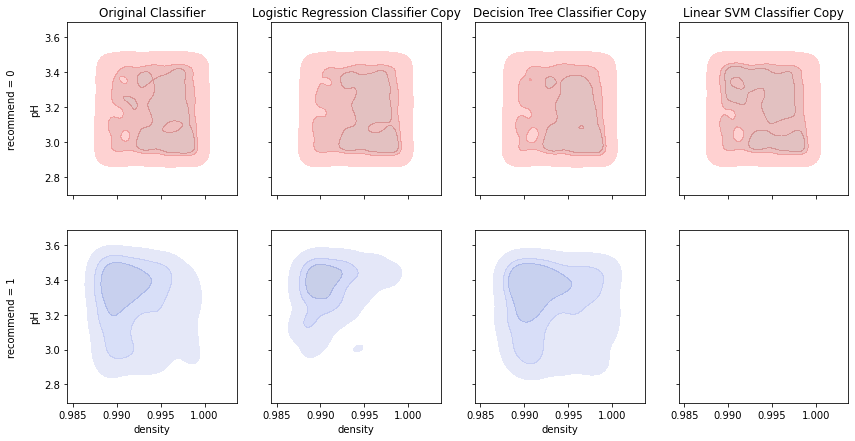

In [18]:
%%capture --no-display
feature1 = "density"
feature2 = "pH"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, 
                                     label_col="recommend", titles=titles, other_kwargs=other_kwargs)

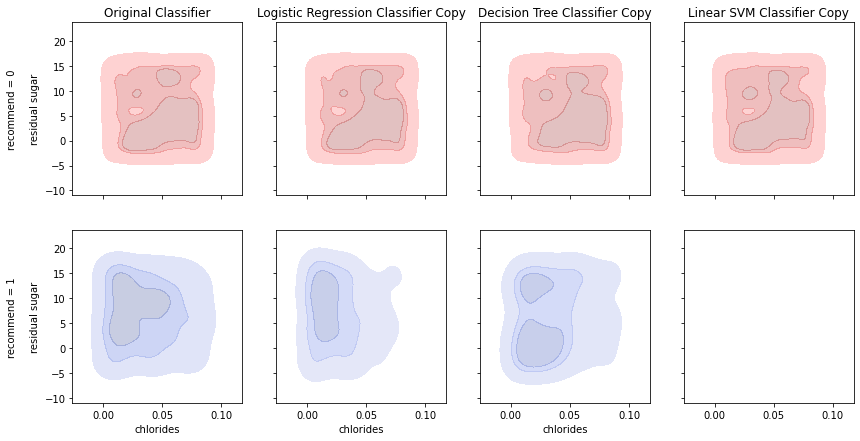

In [19]:
%%capture --no-display
feature1 = "chlorides"
feature2 = "residual sugar"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, 
                                     label_col="recommend", titles=titles, other_kwargs=other_kwargs)

[Index](#Index)  
  
  

-----
-----